In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error
from tqdm import tqdm

from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RepeatedKFold

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.metrics import PredictionErrorDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder

from textwrap import wrap

from main.components.scaler import Scaler
from main.components.imputer import Imputer
from main.components.one_hot_encoder import CustomOneHotEncoder
from main.constants import CATEGORICAL_ATTRIBUTES, CONTINUOUS_ATTRIBUTES, IGF, PROLACTIN, VITAMINE_D, PCO
from main.components.preprocessing_methods import get_continuous_attributes_except, explore_all_variations_of_preprocessing
from main.components.hyperparameter_tuning_methods import hyperparameter_tuning_general, hyperparameter_tuning_linear

pd.set_option('display.max_columns', None) # enable showing all columns of the df
pd.set_option('display.max_rows', None)
pd.set_option("display.expand_frame_repr", True)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)


In [2]:
dataset_file_path = 'data/preprocessed_dataset.csv'
df = pd.read_csv(dataset_file_path)
df.sample(5)

,"PCO 0-healthy control, 1-PCOS, 2-FHA 3-POF, 4-High Andro",IGF-1 ng/ml (N: 100-311),proBNP,"AMH (ng/ml) *7,14=pmol/l",weight,height (cm),BMI,systolic BP (ciśnienie skurczowe),diastolic BP (ciśnienie rozskurczowe),Hypertension,Waist Circumference (WC),WC>88,Hip Circumference (HC),WHR (Waist/Hip ratio),"WHR>0,85 (WHO)","WHR>0,8 (NIDDK)",WHTR (Waist/Height Ratio),"WHTR>0,5","overweight/obesity 0-normal/low, 1-overweight, 2-obesity","irregular cycles (0-nie, 1-tak)","ovulation (0-brak, 1-obecna)","PCO ovary morfology in USG (0-brak, 1--obecna)","stromal hypertrophy in ovary (0-brak, 1-obecny)",acne,hirsutism,FG score (Ferriman-Gallway score - stopień androgenizacji),hyperandrogenism,hypothyroidism,Volume of the thyroid Right Lobe,Volume of the thyroid Left Lobe,thyroid volume,"nodules 0-lack, 1-RL, 2-LL, 3-both",chronic thyroiditis,Vole of the Right Ovary,Volume of the Left Ovary,ovaries volume - total,follicules >12,hyperlipidemia,elevated LDL and TG,WBC x10^3/ul,neutrophil x10^3/ul,lymphocytes x10^3/ul,monocytes x10^3/ul,eosinocytes x10^3/ul,basophils x10^3/ul,% neutrophil,% lymphocytes,% monocytes,%eosinocytes,%basophils,RBC x10^6ul,Hemoglobin [g/dl],hematocrit [%],HTC/Hb,MCV fl,MCH pg,MCHC g/dl,RDW-CV %,NRBC x10^3/ul,PLT x10^3/ul,PDW fl,MPV fl,P-LCR %,PLT/WBC,MPV/PLT,PLR,limf/mono,NLR (stosunek neutrofili do limfocytów),L/WCC (leukocyty do całkowitej liczby krwinek białych),eos/leukocyty,sodium mmol/l,potassium mmol/l,calcium mg/dl,phosphorus mg/dl,creatinine mg/dl,CRP mg/l,ALT U/l,AST U/l,Bilirubin mg/dl,CHOL mg/dl,CHOL mmol/l,CHOL>200,HDL mg/dl,HDL mmol/l,HDL<50,LDL mg/dl,LDL mmol/l,LDL>135,TG,TG mmol/l,TG>150,Atherogenic index (AI) (LDL-C/HDL-C),coronary risk index (CRI) (TG/HDL-C),VAI - Visceral adiposity index,BAI - Body adiposity index,LAP INDEX - Lipid accumulation product index,TyG Index - Trigliceride-glucose index,AIP -Atherogenic index of plasma,UIBC ug/dl,ferrum ug/dl,TIBC,TSAT,ferritin ng/ml,glucose 0 mg/dl,glucose 120 mg/dl,insulin 0 uU/ml,Insulin 120 uU/ml,HOMA,Matsuda,"QUICKI (N<0,357)",Impaired Fasting Glucose,Impaired Glucose Tolerance,TSH mIU/L,FT3 pmol/l,FT4 pmol/l,Anty-TPO IU/ml,Anty-TG IU/ml,FSH mlU/ml,LH,LH/FSH,prolactin,DHEA-S ug/dl,testosterone nmol/l,T (ng/ml),T/SHBG,E(pg/ml)/T(ng/ml)/,Parathormone pg/ml,cortisol nmol/l 8:00,cortisol nmol/l 18:00,Estradiol pg/ml,SHBG nmol/l,FTI (free testosterone index),ACTH pg/ml,HbA1c %,vitamin 25-OH D ng/ml,Androstendione ng/ml,17-OH-progesterone ng/ml,Dihydrotestosterone pg/ml (N<368),Testosterone/DHT,T/A (testosterone/androstendione),month of birth,quarter of the year,age
804,2,246.0,NaN,NaN,49.2,164.0,18.292683,124.0,65.0,0.0,60.0,0.0,71.0,0.845070,0.0,1.0,0.365854,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,5.227500,3.120000,8.347500,0.0,0.0,8.98000,12.70,21.68000,0.0,0.0,0.0,6.96,3.18,2.96,0.62,0.16,0.04,45.7,42.5,8.9,2.3,0.6,4.19,12.0,36.1,3.008333,86.2,28.6,33.2,13.3,0.0,348.0,13.0,10.8,32.4,50.000000,0.031034,117.567568,4.774194,1.074324,0.425287,0.022989,141.0,3.93,10.30,NaN,0.70,0.3,8.0,11.0,0.28,183.0,4.73238,0.0,63.0,1.62918,0.0,107.5,2.779950,0.0,65.0,0.73385,0.0,1.706349,1.031746,0.712777,25.292683,1.46770,4.314367,0.013573,NaN,NaN,NaN,NaN,NaN,86.0,116.0,8.08,74.97,1.715753,5.85,0.351876,0.0,0.0,2.84,5.14,18.46,6.0,17.0,3.5,15.7,4.485714,615.0,341.0,1.40,0.403458,0.007000,550.242853,35.85,414.0,405.0,222.0,200.0,0.69,17.23,NaN,NaN,2.80,4.91,319.0,0.004389,0.500000,10.0,4.0,20.0
871,2,183.0,NaN,NaN,42.0,160.0,16.406250,96.0,65.0,0.0,59.0,0.0,67.0,0.880597,1.0,1.0,0.368750,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.356000,3.780000,8.136000,0.0,0.0,6.12000,5.24,11.36000,0.0,0.0,0.0,4.96,2.50,2.03,0.36,0.06,0.01,50.4,40.9,7.3,1.2,0.2,4.62,13.1,37.6,2.870229,81.4,28.4,34.8,12.7,0.0,247.0,13.9,11.1,35.6,49.798387,0.044939,121.674877,5.638889,1.231527,0.409274,0.012097,144.0,4.22,9.61,4.18,0.57,NaN,13.0,19.0,0.32,159.0,4.11174,0.0,80.0,2.06880,0.0,68.9,1.781754,0.0,53.0,0.59837,0.0,0.861250,0.662500,0.473798,23.875000,0.59837,4.169870,-0.178814,NaN,NaN,N

### Handle `prolactin` outliers

In [7]:
df[df[PROLACTIN] > 1500][PROLACTIN]

df.loc[df[PROLACTIN] > 1500, PROLACTIN] = None

In [8]:
df_prolactin_cleaned = df.dropna(subset=[PROLACTIN])

X_prolactin, y_prolactin = df_prolactin_cleaned.drop(columns=[PROLACTIN]), df_prolactin_cleaned[PROLACTIN]
X_train_prolactin, X_val_prolactin, y_train_prolactin, y_val_prolactin = train_test_split(X_prolactin, y_prolactin, test_size=0.2, random_state=42)

### Models exploration

In [ ]:
models = [
        DecisionTreeRegressor(max_depth=7, random_state=42),
        Lasso(),
        Ridge(),
        RandomForestRegressor(),
        ]


continuous_preprocessings = {
    'PT_iterative_basic': Pipeline([('scaler', PowerTransformer()), ('imputer', IterativeImputer(initial_strategy='median', max_iter=10, tol=0.01))]),
    'PT_KNN': Pipeline([('scaler', PowerTransformer()), ('imputer', KNNImputer(n_neighbors=9))]),
    'RS_iterative_basic': Pipeline([('scaler', RobustScaler()), ('imputer', IterativeImputer(initial_strategy='median', max_iter=10, tol=0.01))]),
    'RS_KNN': Pipeline([('scaler', RobustScaler()), ('imputer', KNNImputer(n_neighbors=9))]),
}

categorical_preprocessings = {
    'original_ohe_no_imputing': Pipeline([('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'))]),
    'original_ohe_+_impute_knn': Pipeline([('imputer', KNNImputer(n_neighbors=1)), ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'))]),
    'original_ohe_+_impute_rf': Pipeline([('imputer', IterativeImputer(estimator=RandomForestClassifier(), initial_strategy='most_frequent', max_iter=10, random_state=0)), ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'))]),
}


scores_df = explore_all_variations_of_preprocessing(X_train_prolactin, y_train_prolactin, PROLACTIN, models, continuous_preprocessings, categorical_preprocessings)
scores_df

In [ ]:
#  TODO: update
continuous_preprocessor = Pipeline([('scaler', PowerTransformer()), ('imputer', IterativeImputer(initial_strategy='median', max_iter=10, tol=0.01))])
categorical_preprocessor = Pipeline([('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'))])

Fitting 5 folds for each of 4 candidates, totalling 20 fits


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.430e+06, tolerance: 3.988e+03
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END model__alpha=0.1;, score=(train=-139.156, test=-175.931) total time= 1.9min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.375e+06, tolerance: 4.241e+03
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END model__alpha=0.1;, score=(train=-141.345, test=-191.614) total time= 1.9min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.459e+05, tolerance: 3.956e+03
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END model__alpha=0.1;, score=(train=-135.707, test=-197.363) total time= 1.9min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.744e+06, tolerance: 4.418e+03
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END model__alpha=0.1;, score=(train=-147.195, test=-188.604) total time= 1.9min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.644e+06, tolerance: 3.715e+03
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END model__alpha=0.1;, score=(train=-134.744, test=-210.640) total time= 2.0min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 1/5] END model__alpha=1;, score=(train=-143.251, test=-165.556) total time= 1.7min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 2/5] END model__alpha=1;, score=(train=-141.948, test=-177.104) total time= 1.6min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 3/5] END model__alpha=1;, score=(train=-137.900, test=-173.462) total time= 1.9min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 4/5] END model__alpha=1;, score=(train=-146.967, test=-169.129) total time= 1.6min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 5/5] END model__alpha=1;, score=(train=-136.264, test=-186.980) total time= 1.6min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 1/5] END model__alpha=10;, score=(train=-150.333, test=-157.425) total time= 1.7min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 2/5] END model__alpha=10;, score=(train=-151.117, test=-165.902) total time= 1.7min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 3/5] END model__alpha=10;, score=(train=-149.974, test=-163.428) total time= 1.7min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 4/5] END model__alpha=10;, score=(train=-155.076, test=-139.870) total time= 1.6min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 5/5] END model__alpha=10;, score=(train=-144.136, test=-175.643) total time= 1.6min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 1/5] END model__alpha=100;, score=(train=-180.402, test=-172.682) total time= 1.6min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 2/5] END model__alpha=100;, score=(train=-177.591, test=-181.124) total time= 1.6min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 3/5] END model__alpha=100;, score=(train=-177.476, test=-178.313) total time= 1.6min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 4/5] END model__alpha=100;, score=(train=-182.041, test=-165.561) total time= 1.6min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 5/5] END model__alpha=100;, score=(train=-171.127, test=-191.874) total time= 1.6min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


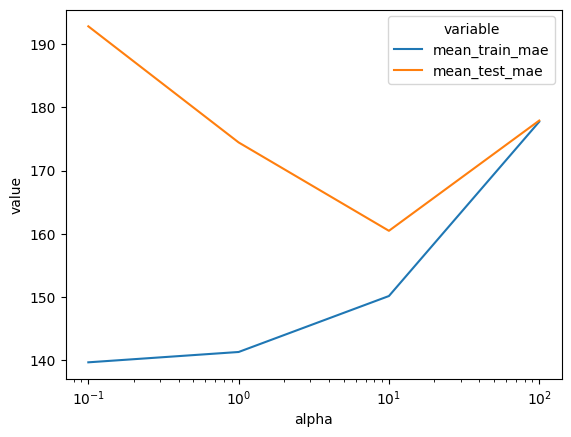

,alpha,mean_train_mae,mean_test_mae
0,0.1,139.629473,192.830362
1,1,141.265876,174.446188
2,10,150.127394,160.453415
3,100,177.727377,177.910705


In [34]:
lasso_model = Lasso()

lasso_param_grid = {
    "model__alpha": [0.1, 1, 10, 100],
    }

prolactin_lasso_model_hyperparam_tuning_df = hyperparameter_tuning_linear(X_train_prolactin, y_train_prolactin, PROLACTIN, Lasso(), continuous_preprocessor, categorical_preprocessor, lasso_param_grid, main_parameter='alpha')
prolactin_lasso_model_hyperparam_tuning_df

Fitting 5 folds for each of 6 candidates, totalling 30 fits


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 1/5] END model__alpha=0.1;, score=(train=-138.910, test=-181.744) total time= 1.7min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 2/5] END model__alpha=0.1;, score=(train=-141.360, test=-196.403) total time= 1.7min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 3/5] END model__alpha=0.1;, score=(train=-135.925, test=-203.464) total time= 1.7min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 4/5] END model__alpha=0.1;, score=(train=-147.134, test=-192.975) total time= 1.7min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 5/5] END model__alpha=0.1;, score=(train=-134.985, test=-218.014) total time= 1.6min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 1/5] END model__alpha=1;, score=(train=-139.531, test=-175.262) total time= 1.7min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 2/5] END model__alpha=1;, score=(train=-141.710, test=-188.767) total time= 1.7min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 3/5] END model__alpha=1;, score=(train=-135.545, test=-195.758) total time= 1.7min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 4/5] END model__alpha=1;, score=(train=-147.146, test=-188.300) total time= 1.6min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 5/5] END model__alpha=1;, score=(train=-135.061, test=-205.942) total time= 1.7min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 1/5] END model__alpha=10;, score=(train=-141.471, test=-167.594) total time= 1.7min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 2/5] END model__alpha=10;, score=(train=-141.660, test=-177.461) total time= 1.6min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 3/5] END model__alpha=10;, score=(train=-136.046, test=-180.166) total time= 1.6min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 4/5] END model__alpha=10;, score=(train=-145.818, test=-174.908) total time= 1.6min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 5/5] END model__alpha=10;, score=(train=-134.993, test=-190.181) total time= 1.7min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 1/5] END model__alpha=100;, score=(train=-143.686, test=-159.764) total time= 1.7min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 2/5] END model__alpha=100;, score=(train=-142.213, test=-167.103) total time= 1.7min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 3/5] END model__alpha=100;, score=(train=-140.335, test=-163.204) total time= 1.7min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 4/5] END model__alpha=100;, score=(train=-145.964, test=-150.056) total time= 1.7min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 5/5] END model__alpha=100;, score=(train=-135.527, test=-179.365) total time= 1.7min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 1/5] END model__alpha=1000;, score=(train=-152.415, test=-155.110) total time= 1.6min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 2/5] END model__alpha=1000;, score=(train=-151.001, test=-165.068) total time= 1.6min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 3/5] END model__alpha=1000;, score=(train=-152.094, test=-160.796) total time= 1.6min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 4/5] END model__alpha=1000;, score=(train=-155.960, test=-138.052) total time= 1.7min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 5/5] END model__alpha=1000;, score=(train=-144.725, test=-178.090) total time= 1.6min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 1/5] END model__alpha=10000;, score=(train=-172.540, test=-167.315) total time= 1.6min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 2/5] END model__alpha=10000;, score=(train=-170.003, test=-175.938) total time= 1.6min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 3/5] END model__alpha=10000;, score=(train=-170.570, test=-172.747) total time= 1.6min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 4/5] END model__alpha=10000;, score=(train=-175.243, test=-157.385) total time= 1.7min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 5/5] END model__alpha=10000;, score=(train=-163.283, test=-187.704) total time= 1.6min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


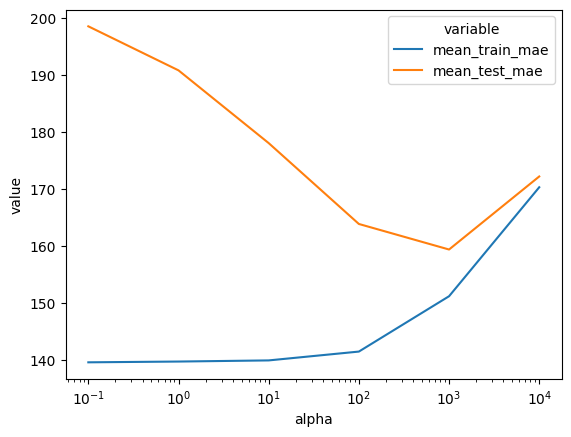

,alpha,mean_train_mae,mean_test_mae
0,0.1,139.662732,198.519946
1,1,139.798610,190.805871
2,10,139.997725,178.062114
3,100,141.544880,163.898222
4,1000,151.238886,159.423166
5,10000,170.327689,172.217883


In [35]:
ridge_param_grid = {
    "model__alpha": [0.1, 1, 10, 100, 1000, 10000],
    }

prolactin_ridge_model_hyperparam_tuning_df =  hyperparameter_tuning_linear(X_train_prolactin, y_train_prolactin, PROLACTIN, Ridge(), continuous_preprocessor, categorical_preprocessor, ridge_param_grid, main_parameter='alpha')
prolactin_ridge_model_hyperparam_tuning_df

In [136]:
tree_model = DecisionTreeRegressor()

tree_param_grid = {
    "model__criterion": ["squared_error", "absolute_error", "poisson", "friedman_mse"],
    "model__max_depth": [2, 4, 6],
    "model__splitter": ["random"],
    "model__min_samples_split": [15, 30],
    "model__min_samples_leaf": [10, 20],
    }

prolactin_tree_model_hyperparam_tuning_df = hyperparameter_tuning_tree(X_train_prolactin, y_train_prolactin, prolactin, tree_model, tree_param_grid)
prolactin_tree_model_hyperparam_tuning_df.sort_values(by='mean_test_mae')

Fitting 5 folds for each of 48 candidates, totalling 240 fits


,params,mean_train_mae,mean_test_mae
12,"{'model__criterion': 'absolute_error', 'model__max_depth': 2, 'model__min_samples_leaf': 10, 'model__min_samples_split': 15, 'model__splitter': 'random'}",157.333158,159.423337
14,"{'model__criterion': 'absolute_error', 'model__max_depth': 2, 'model__min_samples_leaf': 20, 'model__min_samples_split': 15, 'model__splitter': 'random'}",156.347361,161.360029
19,"{'model__criterion': 'absolute_error', 'model__max_depth': 4, 'model__min_samples_leaf': 20, 'model__min_samples_split': 30, 'model__splitter': 'random'}",148.914890,161.485121
15,"{'model__criterion': 'absolute_error', 'model__max_depth': 2, 'model__min_samples_leaf': 20, 'model__min_samples_split': 30, 'model__splitter': 'random'}",156.173668,161.513615
23,"{'model__criterion': 'absolute_error', 'model__max_depth': 6, 'model__min_samples_leaf': 20, 'model__min_samples_split': 30, 'model__splitter': 'random'}",143.385471,162.659732
13,"{'model__criterion': 'absolute_error', 'model__max_depth': 2, 'model__min_samples_leaf': 10, 'model__min_samples_split': 30, 'model__splitter': 'random'}",157.410592,163.182503
17,"{'model__criterion': 'absolute_error', 'model__max_depth': 4, 'model__min_samples_leaf': 10, 'model__min_samples_split': 30, 'model__splitter': 'random'}",146.022732,163.945054
16,"{'model__criterion': 'absolute_error', 'model__max_depth': 4, 'model__min_samples_leaf': 10, 'model__min_samples_split': 15, 'model__splitter': 'random'}",146.605338,165.084994
21,"{'model__criterion': 'absolute_error', 'model__max_depth': 6, 'model__min_samples_leaf': 10, 'model__min_samples_split': 30, 'model__splitter': 'random'}",139.330418,165.760097
20,"{'model__criterion': 'absolute_error', 'model__max_depth': 6, 'model__min_samples_leaf': 10, 'model__min_samples_split': 15, 'model__splitter': 'random'}",136.201193,166.304633


In [ ]:
import nest_asyncio
nest_asyncio.apply()

model = DecisionTreeRegressor(criterion="absolute_error", max_depth=2, min_samples_leaf=10, min_samples_split=15, splitter='random')

compare_random_states(X_train_prolactin, y_train_prolactin, model, prolactin)

## Best models for prolactin

c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


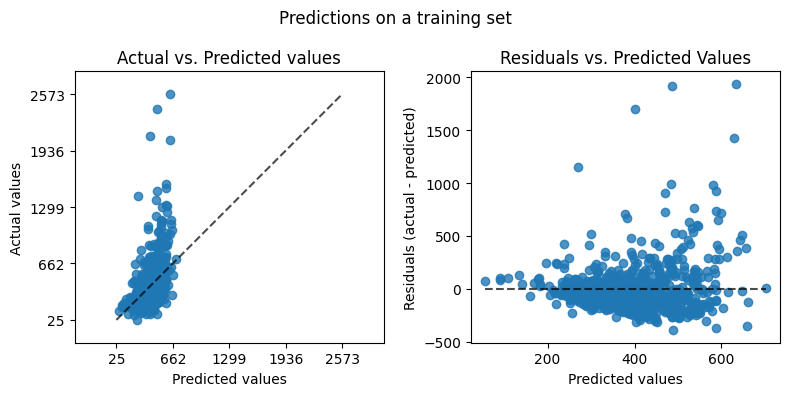

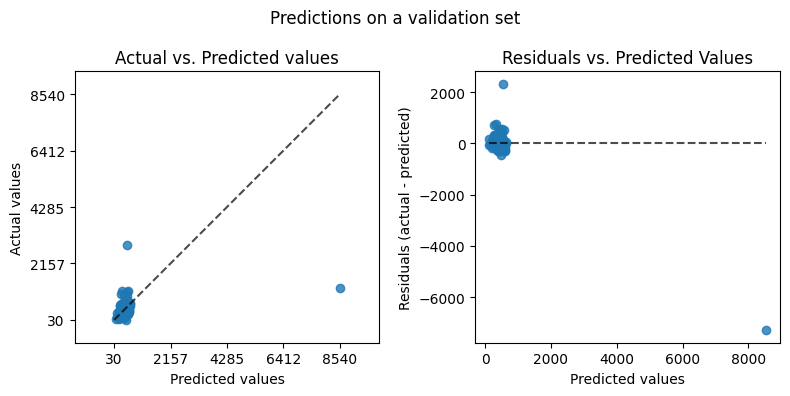

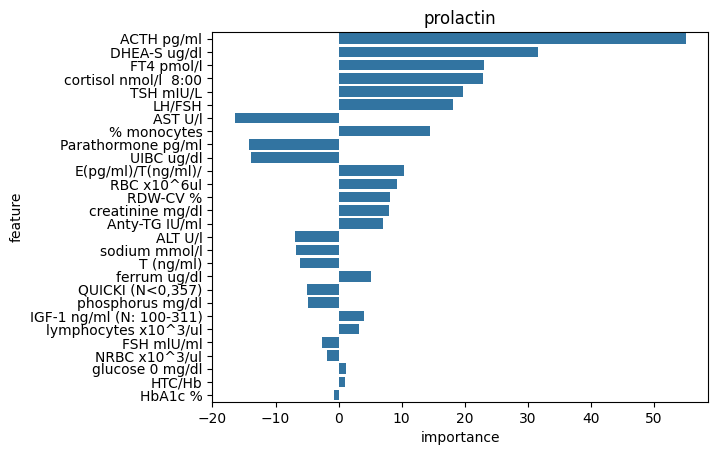

,model,test_set,mse,mae,rmse,r2
0,Lasso(alpha=10),training,57395.679,151.454,239.574,0.223
1,Lasso(alpha=10),validation,377718.767,197.140,614.588,-3.743


In [42]:
lasso_model = Lasso(alpha=10)

prolactin_model_scores_df, feature_importnces_lasso = train_model(lasso_model, prolactin, get_feature_importance_lasso)
prolactin_model_scores_df

c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


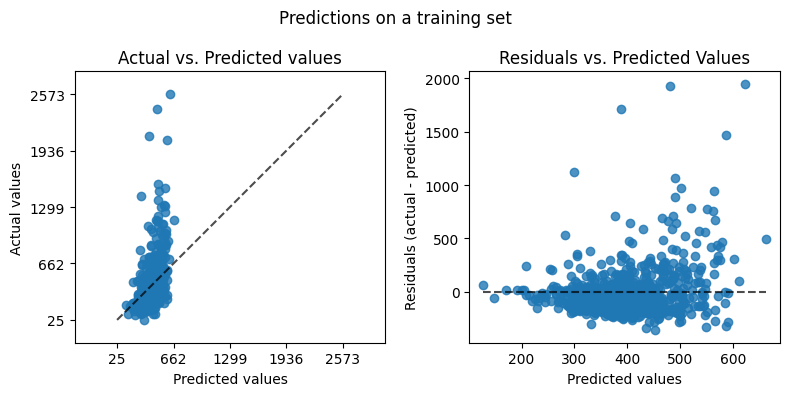

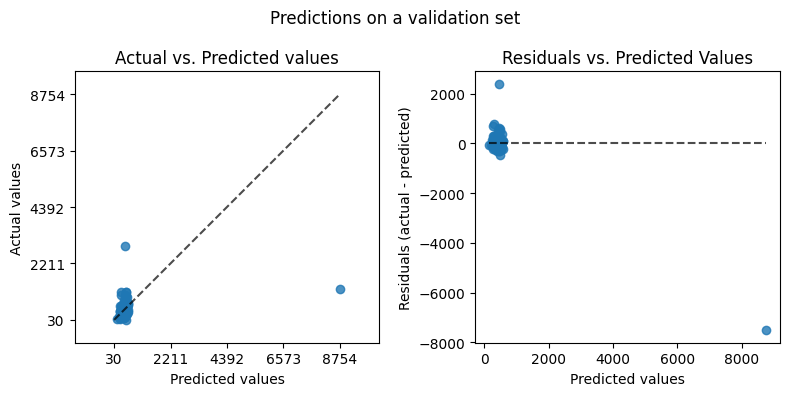

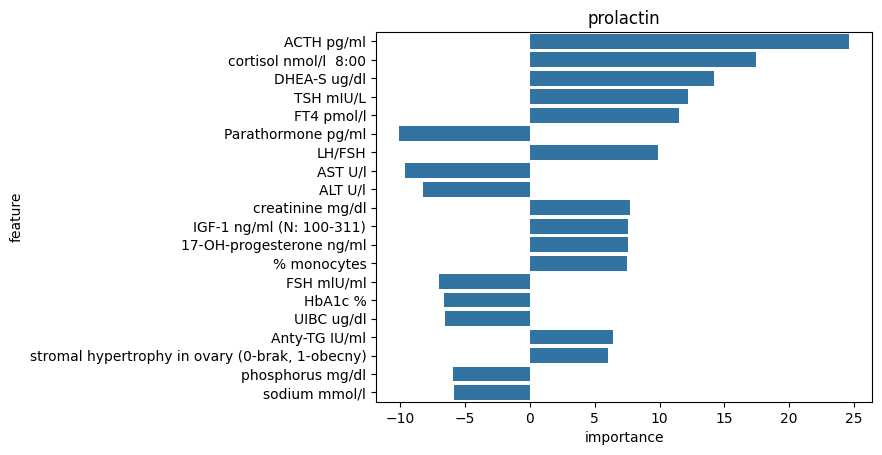

,model,test_set,mse,mae,rmse,r2
0,Ridge(alpha=1000),training,57925.739,150.444,240.678,0.216
1,Ridge(alpha=1000),validation,397035.116,196.155,630.107,-3.986


In [139]:
ridge_model = Ridge(alpha=1000)

prolactin_model_scores_df, feature_importnces_ridge = train_model(ridge_model, prolactin, get_feature_importance_lasso)
prolactin_model_scores_df

c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


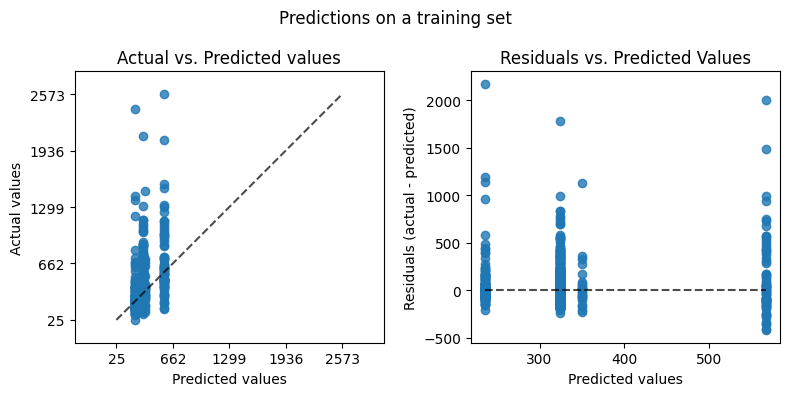

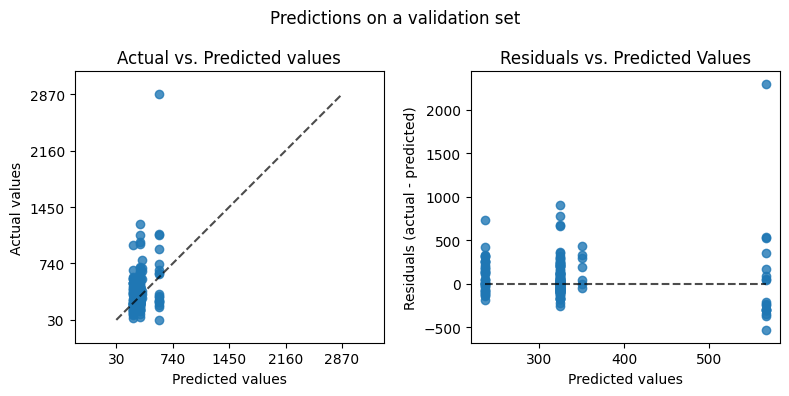

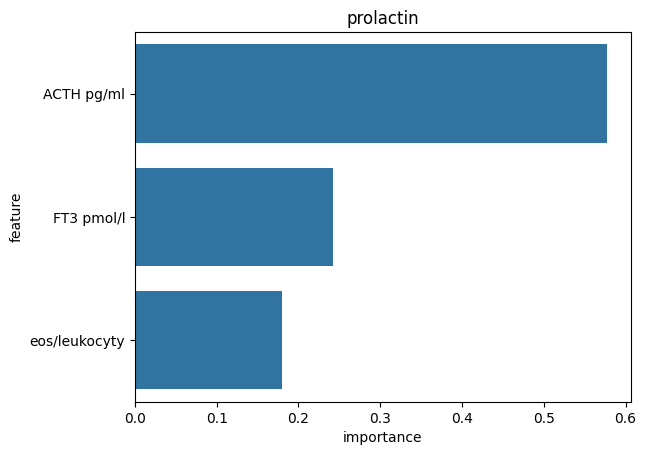

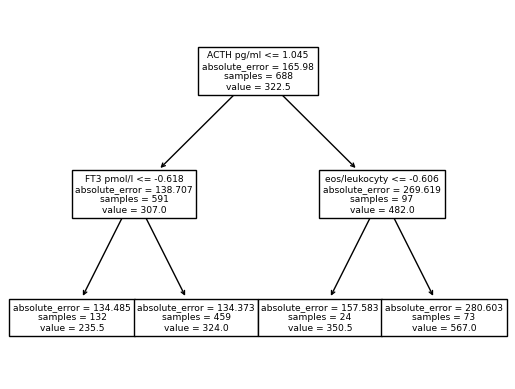

,model,test_set,mse,mae,rmse,r2
0,"DecisionTreeRegressor(criterion='absolute_error', max_depth=2,\n min_samples_leaf=10, min_samples_split=15,\n random_state=42)",training,68261.703,150.719,261.269,0.076
1,"DecisionTreeRegressor(criterion='absolute_error', max_depth=2,\n min_samples_leaf=10, min_samples_split=15,\n random_state=42)",validation,78508.526,164.669,280.194,0.014


In [118]:
tree_model = DecisionTreeRegressor(criterion="absolute_error", max_depth=2, min_samples_leaf=10, min_samples_split=15, random_state=42)

prolactin_model_scores_df, feature_importnces_tree = train_model(tree_model, prolactin, get_feature_importance_tree)
prolactin_model_scores_df